In [14]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline 
import tensorflow as tf 
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model , load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix
from PIL import Image 

### Chargement du modèle depuis l'ensemble de données

In [15]:
loaded_model = load_model('/kaggle/input/testing-model/modele_sol2.h5')

# Creation dataframe Test

In [16]:
repertoire_age_list=[]
reference_age_list=[]
face_id_age_list=[]
repertoire_gender_list=[]
reference_gender_list=[]
face_id_gender_list=[]
ages = []
genders=[]

#Ouverture du fichier texte
#On utilise le fold 3
chemin_fichier_age = '/kaggle/input/adience-dataset/train_val_txt_files_per_fold/test_fold_is_3/age_test.txt'
with open(chemin_fichier_age, 'r') as fichier_age_test:
# Lecture ligne par ligne
     for ligne in fichier_age_test:
# Division de la ligne en référence et âge
           elements = ligne.strip().split()
           if len(elements) == 2:  # Assurez-vous qu'il y a deux éléments sur la ligne
                image, age = elements
                repertoire = image.split('/')[0]
                reference=image.split('/')[1]
                face_id = reference.split('.')[1]
                repertoire_age_list.append(repertoire)
                reference_age_list.append(reference)
                face_id_age_list.append(int(face_id))
                ages.append(int(age))  # Convertissez l'âge en entier si nécessaire
#for fold in 2:
chemin_fichier_gender ='/kaggle/input/adience-dataset/train_val_txt_files_per_fold/test_fold_is_3/gender_test.txt'
with open(chemin_fichier_gender, 'r') as fichier_gender_test:
# Lecture ligne par ligne
     for ligne in fichier_gender_test:
# Division de la ligne en référence et âge
           elements = ligne.strip().split()
           if len(elements) == 2:  # Assurez-vous qu'il y a deux éléments sur la ligne
                image, gender = elements
                repertoire = image.split('/')[0]
                reference=image.split('/')[1]
                face_id = reference.split('.')[1]
                repertoire_gender_list.append(repertoire)
                reference_gender_list.append(reference)
                face_id_gender_list.append(int(face_id))
                genders.append(int(gender))  
                        
# Création du DataFrame

data_age_test= {'Répertoire': repertoire_age_list, 'Reference_image':reference_age_list,'Face_id':face_id_age_list,'Age': ages}
df_age_test = pd.DataFrame(data_age_test)
data_gender_test = {'Répertoire': repertoire_gender_list, 'Reference_image':reference_gender_list,'Face_id':face_id_gender_list, 'Gender': genders}
df_gender_test = pd.DataFrame(data_gender_test)
# Retirer 50% des lignes avec l'âge 4 de manière aléatoire
rows_to_remove = df_age_test[df_age_test['Age'] == 4].sample(frac=0.5)  
df_age_test = df_age_test.drop(rows_to_remove.index)

In [17]:
df_test = pd.merge(df_age_test, df_gender_test[['Face_id', 'Gender']], on=['Face_id']).drop_duplicates().reset_index(drop=True)

In [27]:
df_test.shape

(2426, 5)

# Analyse des données

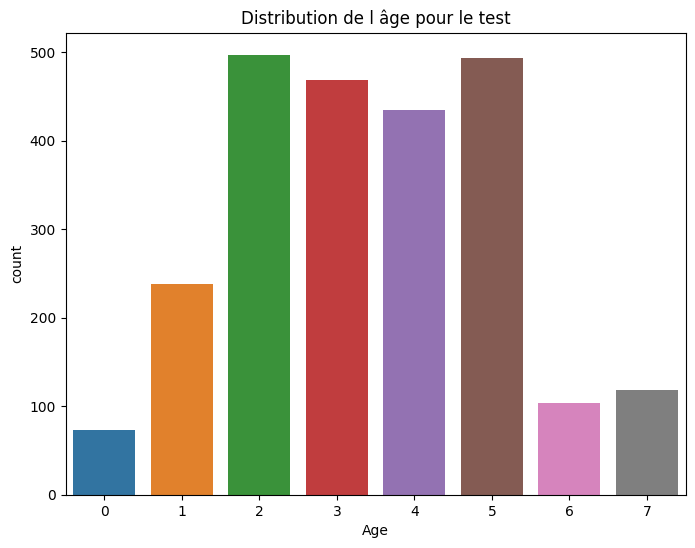

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Age', data=df_test)
plt.title('Distribution de l âge pour le test')
plt.show()

### Distribution des genres données Test

In [1]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=df_gender_test)
plt.title('Distribution des genres données Test')
plt.show()

NameError: name 'plt' is not defined

### Extraction des caractériqtiques

In [19]:
from tqdm import tqdm

def extract_features(images, normalize=True):
    features = []
    for image in tqdm(images): 
        img = load_img('/kaggle/input/aligned/aligned/' + image)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        
        if normalize:
            img = img / 255.0  # Normalisation des valeurs de pixel dans la plage [0, 1]
        
        features.append(img)
        
    features = np.array(features)
    return features


In [20]:
X_test = extract_features(df_test['Répertoire'].values+'/'+df_test['Reference_image'].values)

100%|██████████| 2426/2426 [00:40<00:00, 60.45it/s]


In [21]:
X_test.shape

(2426, 128, 128, 3)

# Accuracy du Modèle Total

In [22]:
predictions =loaded_model.predict(X_test)
predicted_classes = np.argmax(predictions[:,:], axis=1)
print(predicted_classes)
true_classes=df_test['Age']*2 + df_test['Gender']
test_accuracy_model = accuracy_score(true_classes, predicted_classes)
print(f"Test Accuracy: {test_accuracy_model * 100:.2f}%")



76/76 [==============================] - 11s 149ms/step
[ 7  7  3 ...  7  8 12]
Test Accuracy: 76.79%


In [23]:
from keras.utils import to_categorical

# Convertir les étiquettes vraies en format one-hot encoding
true_classes_one_hot = to_categorical(true_classes, num_classes=16)

# Évaluer le modèle avec les données de test
loss, accuracy = loaded_model.evaluate(X_test, true_classes_one_hot, verbose=0)
print(f"Loss sur les données de test : {loss}")
print(f"Accuracy sur les données de test : {accuracy}")


Loss sur les données de test : 1.2475084066390991
Accuracy sur les données de test : 0.7679307460784912


# Construction des veteurs relatifs à l'âge et le genre d'aprés les prédiction du modéle

In [24]:
predicted_classes = np.argmax(predictions[:,:], axis=1)
print(predicted_classes)

age_vector = (predicted_classes % 16) // 2
gender_vector = predicted_classes % 2

print("Vecteur pour l'âge :", age_vector)
print("Vecteur pour le genre :", gender_vector)

[ 7  7  3 ...  7  8 12]
Vecteur pour l'âge : [3 3 1 ... 3 4 6]
Vecteur pour le genre : [1 1 1 ... 1 0 0]


# Accuracy par rapport au genre ignorant l'âge 

In [25]:
true_gender = df_test['Gender'].values
accuracy_gender_only = accuracy_score(true_gender, gender_vector)
print(f"Gender Accuracy (ignorant l'âge) : {accuracy_gender_only * 100:.2f}%")

Gender Accuracy (ignorant l'âge) : 92.17%


# Accuracy par rapport à l'âge ignorant le genre 

In [26]:
true_age = df_test['Age'].values
accuracy_age_only = accuracy_score(true_age, age_vector )
print(f"Age Accuracy (ignorant le genre) : {accuracy_age_only * 100:.2f}%")

Age Accuracy (ignorant le genre) : 79.06%
